In [115]:
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
%cd ~/Workspace/research/sshmm/stats/stats_data

num_states = 10

with open(f'idx2state_{num_states}.json', 'r') as f:
    idx2state = json.load(f)
    
idx2state = {k: v.split('<-')[0].strip() for k, v in idx2state.items()}

/atm/duck/nest/data/tmcalls/roylu/stats_data


In [116]:
ls state_seq

bk/  dev_states_10.csv  dev_states_7.csv


In [117]:
msa = pd.read_csv('msa_0.15.csv', sep='|')
lsa = pd.read_csv('lsa_0.15.csv', sep='|')
df = pd.read_csv(f'state_seq/dev_states_{num_states}.csv', sep='|')
m = msa.sourcemediaid.tolist()
l = lsa.sourcemediaid.tolist()
mdf = df[df.sourcemediaid.isin(m)]
ldf = df[df.sourcemediaid.isin(l)]
mdf = mdf.merge(msa[['sourcemediaid', 'agent_type']], on='sourcemediaid')
ldf = ldf.merge(lsa[['sourcemediaid', 'agent_type']], on='sourcemediaid')
mdf['call_length'] = mdf.states.apply(lambda x: len(x.strip().split(',')))
ldf['call_length'] = ldf.states.apply(lambda x: len(x.strip().split(',')))        
mdf = mdf[(mdf['call_length'] >= 10) & (mdf['call_length'] <= 50)]
ldf = ldf[(ldf['call_length'] >= 10) & (ldf['call_length'] <= 50)]

/g/tial/transitory/roylu/miniconda3/envs/hmm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [118]:
from collections import Counter, defaultdict

def r(df):
    ret = {}
    for k in ['msa_cb', 'msa_ncb', 'lsa_cb', 'lsa_ncb']:
        ret[k] = defaultdict(list)
        
    for s, a in df[['states', 'agent_type']].itertuples(index=False):
        s = s.split(',')
        total = len(s)
        cnt = Counter(s)
        for state_idx, c in cnt.items():
            ret[a][state_idx].append(c/total)

    for agent_type, state_idx2ratios in ret.items():
        for state_idx, ratios in list(state_idx2ratios.items()):
            state = idx2state[state_idx]
            ret[agent_type][state] = sum(ratios) / len(ratios)
            del ret[agent_type][state_idx]
        
    return ret

In [119]:
df2 = pd.concat([mdf, ldf])
dic = r(df2)

lst = []
for agent_type, state2ratio in dic.items():
    for state, ratio in state2ratio.items():
        lst.append((agent_type, state, ratio))

df3 = pd.DataFrame(lst, columns=['agent_type', 'state', 'ratio'])

In [120]:
print('number of msa = ', len(mdf))
print('number of lsa = ', len(ldf))

number of msa =  169
number of lsa =  479


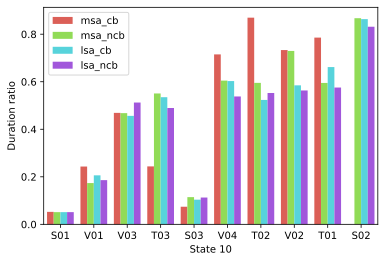

In [121]:
g = sns.barplot(
    x='state',
    y='ratio',
    hue='agent_type',
    data=df3,
    palette = 'hls',  
    capsize = 0.05,             
    saturation = 8,             
    errcolor = 'gray',
    errwidth = 2,  
    ci = 'sd'
)
g.set(xlabel=f'State {num_states}', ylabel='Duration ratio')
plt.legend(loc='upper left')